# IRIS Flower Classification

## Introduction

The Iris dataset is a popular choice for classification tasks in machine learning. It contains measurements of four features (sepal length, sepal width, petal length, and petal width) of iris flowers belonging to three different species: setosa, versicolor, and virginica.

Our goal is to build a machine learning model that can accurately classify iris flowers into their respective species based on these four features. This is a supervised learning problem, as we have labeled data with the correct species for each sample. Since we are predicting a categorical variable (the species), this is a classification task.

We will explore different classification algorithms, such as k-nearest neighbors, decision trees, and logistic regression, to determine which model performs best on the Iris dataset. By the end of this project, we aim to build a model that can accurately classify iris flowers based on their measurements.


## Table of Contents
---
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
- [Reviewing Summary Statistics](#Reviewing-Summary-Statistics)
- [Data Preprocessing](#Data-Preprocessing)
- [Model Preparation](#Model-Preparation)
- [Model Results](#Model-Results)
  - [Confusion Matrices](#Confusion-Matrices)
  - [Dimensionality Reduction through PCA](#Dimensionality-Reduction-through-PCA)
  - [Feature Importance](#Feature-Importance)
- [Best Performing Model](#Best-Performing-Model)  
- [Discussion and Recommendations](#Discussion-and-Recommendations)

## Exploratory Data Analysis
We start by installing the necessary modules and importing the necessary libraries.

In [1]:
%%capture
!pip install pandas
!pip install sqlite3
!pip install sqlalchemy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

In [2]:
# Process and Visualize data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats, interp
from scipy.stats import shapiro
from sqlalchemy import create_engine
import seaborn as sns
import datetime

# Preprocess data
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder, StandardScaler

# Feature selection
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn import ensemble
import xgboost as xgb

# Read the full contents of the dataframes
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

Next, we will load the data into a SQLite database. We will be working with the [Iris Dataset](https://archive.ics.uci.edu/dataset/53/iris) from the UC Irvine Machine Learning Repository. This dataset contains plant information in a file named `IRIS.csv`.

In [3]:
# Load the IRIS CSV file into a DataFrame
url = "https://raw.githubusercontent.com/matthewshawnkehoe/Iris-Classification/main/IRIS.csv"
iris_df = pd.read_csv(url)

# Create an SQLite engine
engine = create_engine('sqlite:///iris.db')

# Load the DataFrame into the SQLite database
iris_df.to_sql('iris', engine, index=False, if_exists='replace')

# Look at shape of the dataframe
iris_df.shape


(152, 5)

In [4]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris_df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [6]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  152 non-null    float64
 1   sepal_width   152 non-null    float64
 2   petal_length  152 non-null    object 
 3   petal_width   152 non-null    object 
 4   species       151 non-null    object 
dtypes: float64(2), object(3)
memory usage: 6.1+ KB


We can see that there are 152 records and 5 columns. Four columns are numeric and represent continuous data while the `species` column is categorical and stores one of three different flower types (setosa, versicolour, and virginica). The column data is as follows:

- `sepal_length:` the sepal length (in cm)
- `sepal_width:` the sepal width (in cm)
- `petal_length:` the petal length (in cm)
- `petal_width:` the pedal width (in cm)
- `species:` the type of flower (one of setosa, versicolour, or virginica)

## Data Cleaning

We will now examine null records.

In [7]:
# Check for missing values
missing_values = iris_df.isna().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         1
dtype: int64


In [8]:
# Determine rows with null values
null_rows = iris_df[iris_df.isna().any(axis=1)]
print(null_rows)

    sepal_length  sepal_width petal_length  petal_width species
22           3.7          1.5          0.4  Iris-setosa     NaN


The species in row 22 is missing. From reviewing other data, we can see that the species was put inside the `pedal_width` column and that we should shift the other columns to the right and replace the `sepal_length` column. We now fix the missing values.

In [9]:
# Calculate the average sepal length
avg_sepal_length = iris_df['sepal_length'].mean()

# Define a function to shift columns to the right for rows with null species
def shift_row(row):
    """
    Shifts columns to the right for rows with null sepal_length, replacing
    the null sepal_length with the mean sepal_length.

    Parameters:
    - row: pd.Series
        The row of the DataFrame.

    Returns:
    - pd.Series
        The shifted row.
    """
    if pd.isnull(row['species']):
        return pd.Series([row['petal_width'], row['petal_length'],
                          row['sepal_width'], row['sepal_length'],
                          avg_sepal_length],
                         index=['species', 'petal_width', 'petal_length',
                                'sepal_width', 'sepal_length'])
    return row


# Apply the function to each row
iris_df = iris_df.apply(shift_row, axis=1)

# Confirm no missing values remain
missing_values_after = iris_df.isnull().sum()
print("Missing values after handling:\n", missing_values_after)

Missing values after handling:
 petal_length    0
petal_width     0
sepal_length    0
sepal_width     0
species         0
dtype: int64


We now re-examine row 22.

In [10]:
print(iris_df.iloc[22])

petal_length            1.5
petal_width             0.4
sepal_length       5.831579
sepal_width             3.7
species         Iris-setosa
Name: 22, dtype: object


Let's also make sure that all of the numerical columns have valid numerical data. If these aren't valid numerical data, we will replace the data with the column mean.

In [11]:
def convert_columns_to_numeric(df, columns):
    """
    Convert specified columns of a DataFrame to numeric, coercing errors to NaN.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the columns to convert.
    columns (list of str): The list of column names to convert to numeric.

    Returns:
    pandas.DataFrame: The DataFrame with specified columns converted to numeric.
    """
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Specify the features to convert
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']

# Convert the specified columns to numeric
iris_df = convert_columns_to_numeric(iris_df, features)

In [12]:
# Calculate the mean of the 'petal length' column for each species
species_means = iris_df.groupby('species')['petal_length'].mean()

# Fill NaN values with the species-specific mean
def fill_na_with_species_mean(row):
    if pd.isna(row['petal_length']):
        return species_means[row['species']]
    else:
        return row['petal_length']

# Apply the function to the Iris Dataframe
iris_df['petal_length'] = iris_df.apply(fill_na_with_species_mean, axis=1)

Let's also handle outliers.

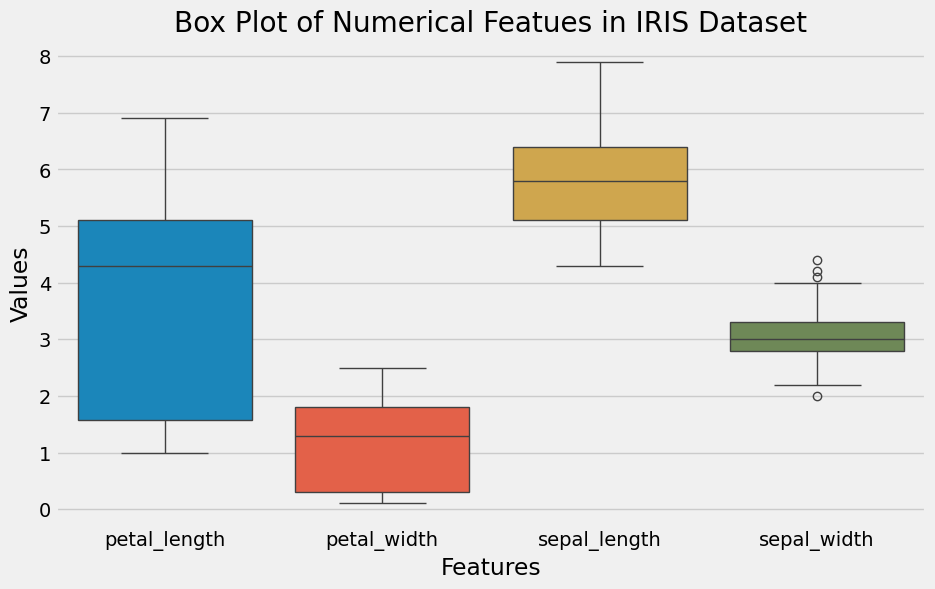

In [13]:
# Create a box plot for all numerical columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=iris_df[features])
plt.title('Box Plot of Numerical Featues in IRIS Dataset')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

Let's handle the outliers in the sepal width feature. There are four outliers.

In [14]:
# Calculate the IQR for sepal width
q1 = iris_df['sepal_width'].quantile(0.25)
q3 = iris_df['sepal_width'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lof = q1 - 1.5 * iqr
ufo = q3 + 1.5 * iqr

# Identify the outliers
outliers1 = iris_df[iris_df['sepal_width'] < lof]
outliers2 = iris_df[iris_df['sepal_width'] > ufo]

# Combine the outliers using concat
outliers = pd.concat([outliers1, outliers2])

# Print the results
print(f"Lower Outlier Fence (LOF): {lof}")
print(f"Upper Outlier Fence (UFO): {ufo}")
print("Outliers:")
print(outliers)

Lower Outlier Fence (LOF): 2.05
Upper Outlier Fence (UFO): 4.05
Outliers:
    petal_length  petal_width  sepal_length  sepal_width          species
61           3.5          1.0           5.0          2.0  Iris-versicolor
15           1.5          0.4           5.7          4.4      Iris-setosa
33           1.5          0.1           5.2          4.1      Iris-setosa
34           1.4          0.2           5.5          4.2      Iris-setosa


However, these look fine from our histogram. We will not remove these four outliers.

Text(0.5, 1.0, 'Histogram of Sepal Width')

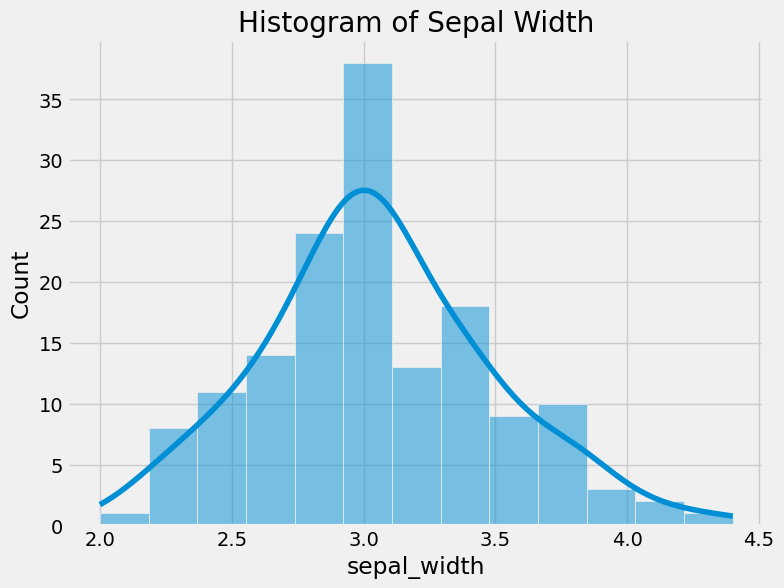

In [15]:
plt.figure(figsize=(8, 6))
ax = sns.histplot(iris_df['sepal_width'], kde=True)
ax.set_title('Histogram of Sepal Width')

## Data Visualization


We then create pairplots to explore our four numerical features.

<Figure size 1400x1400 with 0 Axes>

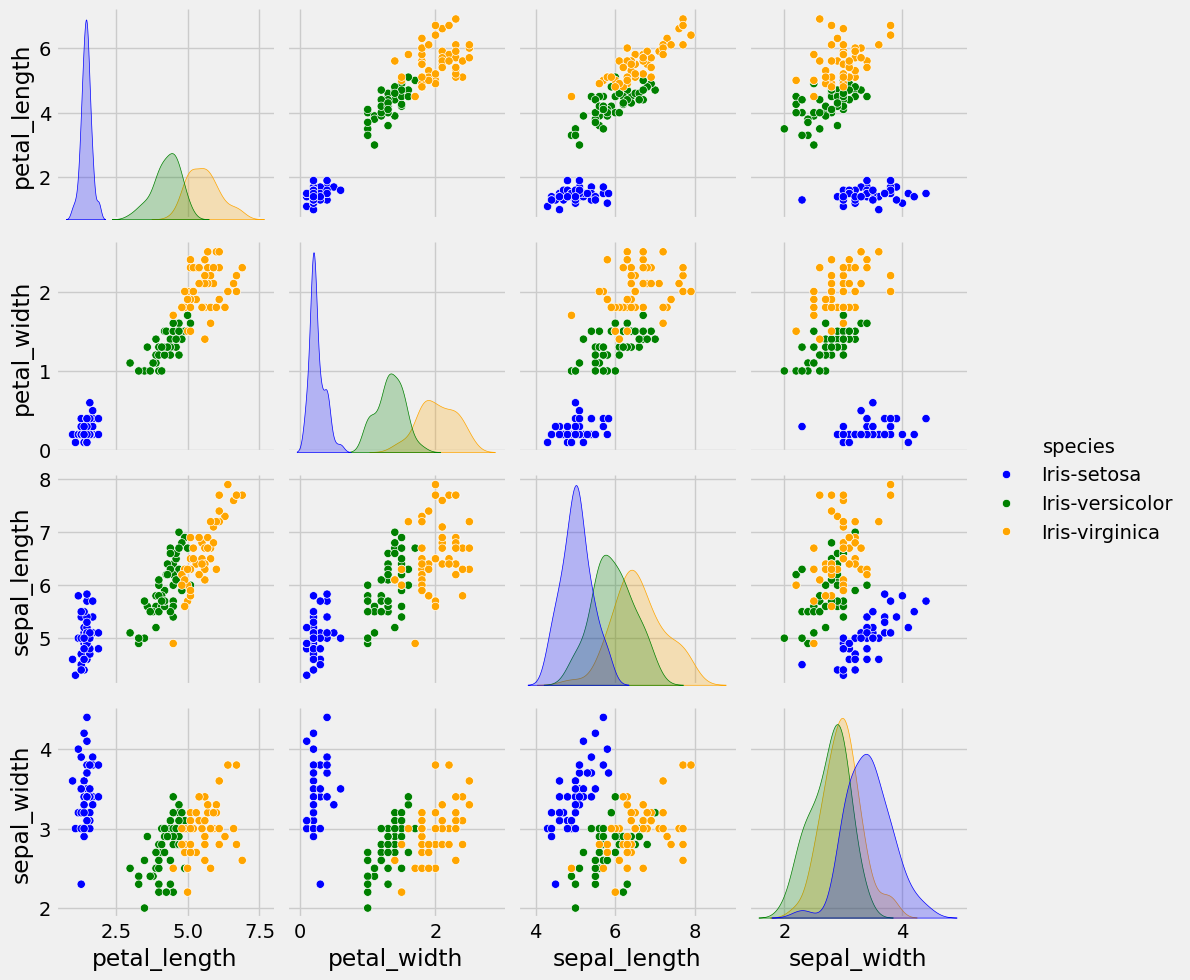

In [16]:
# Define the color palette
palette = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "orange"}

# Create the pairplot
plt.figure(figsize=(14, 14))
sns.pairplot(data=iris_df, hue='species', palette=palette)
plt.show()

**Scatter Plot Analysis**

1. Sepal Length

  a. Sepal Length vs Sepal Width
  - **Iris setosa**: Almost distinguishable.
  - **Iris versicolor and Iris virginica**: Highly colocated.

  b. Sepal Length vs Petal Length
  - **Iris setosa**: Completely distinct.
  - **Iris versicolor and Iris virginica**: Almost linearly separable.

  c.  Sepal Length vs Petal Width
  - **Iris setosa**: Completely separable.
  - **Iris versicolor and Iris virginica**: Colocated.

2. Sepal Width

  a. Sepal Width vs Petal Length
  - **Iris setosa**: Completely separable.
  - **Iris versicolor and Iris virginica**: Colocated.

  b. Sepal Width vs Petal Width
  - **Iris setosa**: Completely separable.
  - **Iris versicolor and Iris virginica**: Colocated.

3. Petal Length

  a. Petal Length vs Petal Width
  - **Iris setosa**: Completely separable.
  - **Iris versicolor and Iris virginica**: Colocated.

**Distribution Plot Analysis**

1. Sepal Length
  - All three species moderately overlap, making them indistinguishable based on sepal length alone.

2. Sepal Width
  - All three species have similar sepal widths.

3. Petal Length
  - **Iris setosa**: Shortest petal length.
  - **Iris versicolor and Iris virginica**: Similar petal lengths, with Iris versicolor having slightly shorter petals than Iris virginica.

4. Petal Width
  - **Iris setosa**: Smallest petal width.
  - **Iris versicolor and Iris virginica**: Similar petal widths.

Next, we review a histogram of the four numerical features.

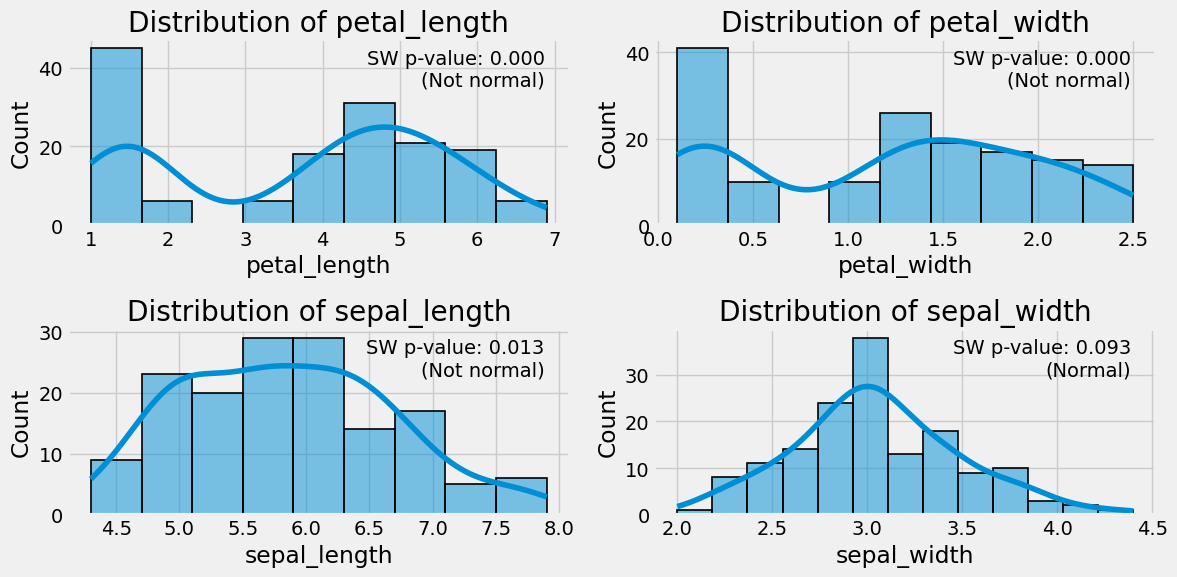

In [17]:
from scipy.stats import shapiro

# Plot histograms with KDE for each feature column and add normal distribution curves
plt.figure(figsize=(12, 6))
for i, column in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(iris_df[column], kde=True, edgecolor='black', linewidth=1.2)

    # Perform Shapiro-Wilk test for normality
    stat, p = shapiro(iris_df[column])

    # Add annotation with test result
    is_normal = 'Normal' if p > 0.05 else 'Not normal'
    plt.text(0.95, 0.95, f'SW p-value: {p:.3f}\n({is_normal})', ha='right', va='top', transform=plt.gca().transAxes)

    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

We see that Pedal Length, Pedal Width, and Sepal Length are not normally distributed. Pedal Length and Pedal Width have over 40 values with small values. The distribution of Sepal Width looks fairly normal. For a final visualization, let's look at a violin plot of the three flower species.

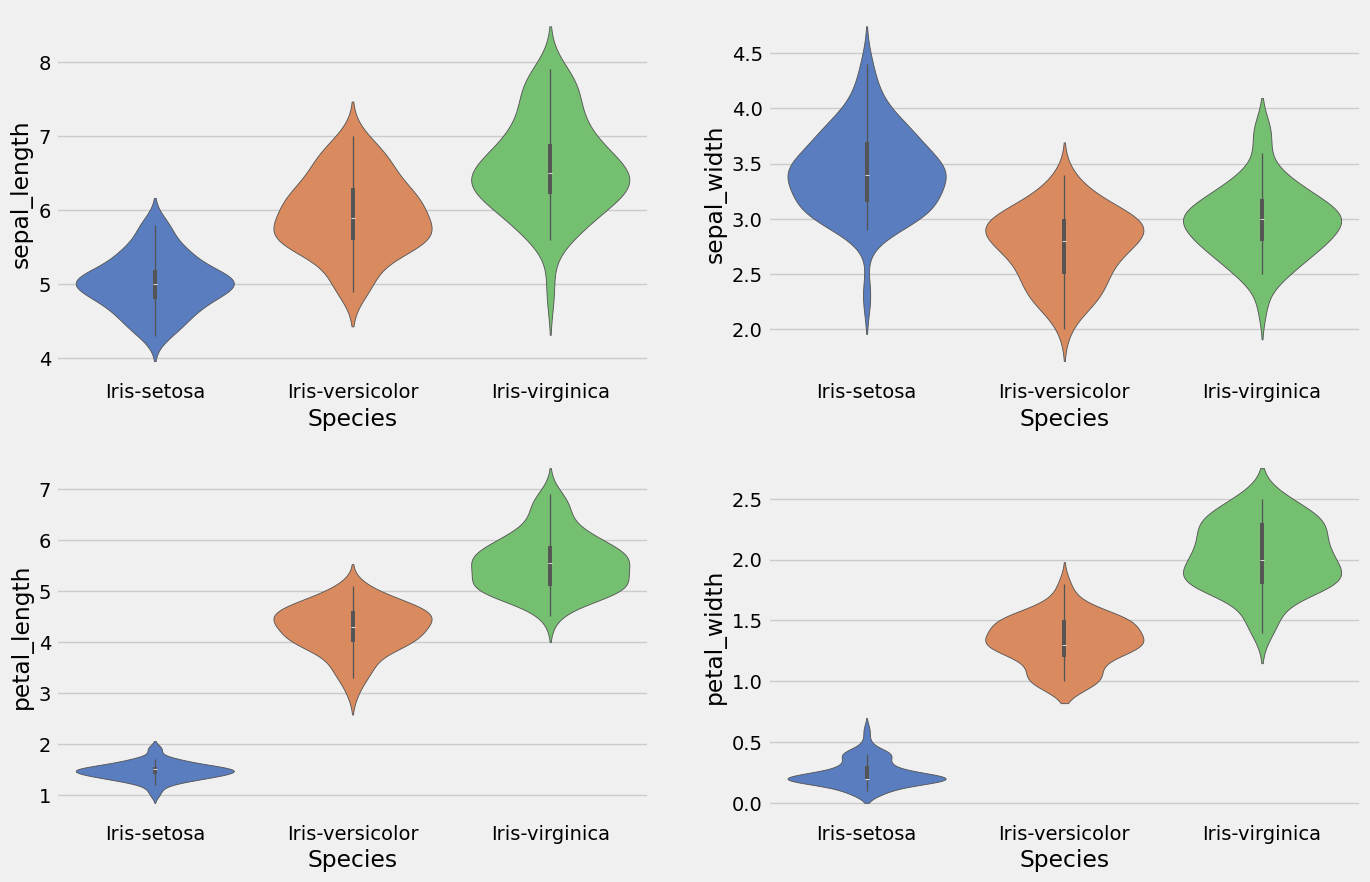

In [18]:
# Define a function to create a violin plot
def plot_violin(subplot_position, y):
    plt.subplot(subplot_position)
    ax = sns.violinplot(x='species', y=y, data=iris_df, hue='species', palette='muted', legend=False)
    ax.set_xlabel('Species')

# Set up the figure size
plt.figure(figsize=(15, 10))

# Define features for the plots
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Create the violin plots
for i, feature in enumerate(features, start=1):
    plot_violin(220 + i, feature)

## Reviewing Summary Statistics

Let's first group the data by the three flower species.

In [19]:
iris_species = iris_df.groupby('species')
iris_species.describe().T

species             Iris-setosa  Iris-versicolor  Iris-virginica
petal_length count    51.000000        51.000000       50.000000
             mean      1.464706         4.260000        5.552000
             std       0.171841         0.465188        0.551895
             min       1.000000         3.000000        4.500000
             25%       1.400000         4.000000        5.100000
             50%       1.500000         4.300000        5.550000
             75%       1.550000         4.600000        5.875000
             max       1.900000         5.100000        6.900000
petal_width  count    51.000000        51.000000       50.000000
             mean      0.247059         1.329412        2.026000
             std       0.108357         0.197276        0.274650
             min       0.100000         1.000000        1.400000
             25%       0.200000         1.200000        1.800000
             50%       0.200000         1.300000        2.000000
             75%       0.300000         1.500000        2.300000
             max       0.600000         1.800000        2.500000
sepal_length count    51.000000        51.000000       50.000000
             mean      5.022188         5.941176        6.588000
             std       0.367598         0.512319        0.635880
             min       4.300000         4.900000        4.900000
             25%       4.800000         5.600000        6.225000
             50%       5.000000         5.900000        6.500000
             75%       5.200000         6.300000        6.900000
             max       5.831579         7.000000        7.900000
sepal_width  count    51.000000        51.000000       50.000000
             mean      3.423529         2.758824        2.974000
             std       0.379256         0.320734        0.322497
             min       2.300000         2.000000        2.200000
             25%       3.150000         2.500000        2.800000
             50%       3.400000         2.800000        3.000000
             75%       3.700000         3.000000        3.175000
             max       4.400000         3.400000        3.800000

We see that this matches the visualizations performed in our data exploration. Alternatively, we can review the summary statistics for the entire Dataframe.

In [20]:
iris_df.describe().T

,count,mean,std,min,25%,50%,75%,max
petal_length,152.0,3.747105,1.762742,1.0,1.575,4.3,5.1,6.9
petal_width,152.0,1.195395,0.761259,0.1,0.300,1.3,1.8,2.5
sepal_length,152.0,5.845602,0.823073,4.3,5.100,5.8,6.4,7.9
sepal_width,152.0,3.052632,0.439438,2.0,2.800,3.0,3.3,4.4


## Data Preprocessing

In [21]:
# Encode the species column into numerical values
le = LabelEncoder()
iris_df['species'] = le.fit_transform(iris_df['species'].astype(str))

print(iris_df['species'].value_counts())
print('\n{}'.format(iris_df.info()))

species
0    51
1    51
2    50
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   petal_length  152 non-null    float64
 1   petal_width   152 non-null    float64
 2   sepal_length  152 non-null    float64
 3   sepal_width   152 non-null    float64
 4   species       152 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.1 KB

None


We will now use a heatmap to visualize correlation between columns. We will look at the correlation between all numerical columns and the `species` column (which will be the target variable in our machine learning models).

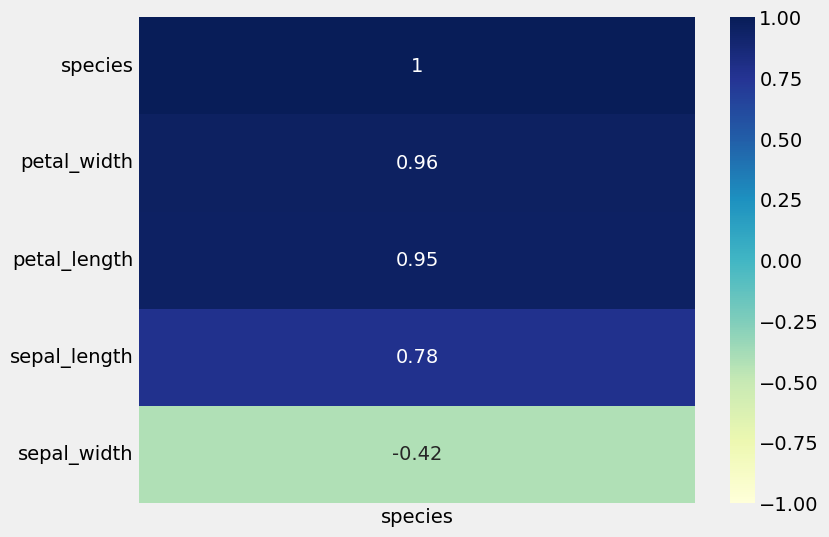

In [22]:
# Convert the species column to numerical values
iris_df['species'] = le.fit_transform(iris_df['species'].astype(str))

fig, ax = plt.subplots(figsize=(8,6))
corr_matrix = np.abs(iris_df.corr())
sns.heatmap(iris_df.corr()[['species']].sort_values('species').tail(10),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

Here we see that highly correlated features are `petal_width`, `pedal_length`, and `sepal_length.` Features that are less correlated are `sepal_width`. For now, we will not drop these columns.

## Model Preparation

We will now separate our data into features and a target. We will choose the flower species as our target variable. The features will be the remaining four columns which we will use to predict the flower species.

Next, we are going to split our data into train and test and look at the shape of the resulting datasets.

In [23]:
X = iris_df.drop('species', axis=1)
y = iris_df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Size of X_train: ", X_train.shape)
print("Size of X_test: ", X_test.shape)
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)

Size of X_train:  (114, 4)
Size of X_test:  (38, 4)
Size of y_train:  (114,)
Size of y_test:  (38,)


Before we start building various machine learning models, we will look at a baseline model to see how well our models perform. Our baseline will be to predict all flowers as one of the three types. Say that we predict all of the flowers are of type `setosa`.

In [24]:
# Set all predictions to be 'setosa'
y_pred_setosa = [0] * len(y)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred_setosa)

print("Accuracy of predicting all flower species as 'setosa': {:.2f}%".format(accuracy * 100))

Accuracy of predicting all flower species as 'setosa': 33.55%


Then, we see that our machine learning models are only useful if they can achieve an accuracy better than 33%.

## Model Results

Let's test several ensemble methods to investigate the performance of different classification algorithms. We will first use a Pipeline to standardize our numerical features.

In [25]:
def evaluate_classifiers(X_train, X_test, y_train, y_test):
    """
    Evaluate multiple classifiers on the given training and test datasets.

    Parameters:
    - X_train: pd.DataFrame
        Training features.
    - X_test: pd.DataFrame
        Test features.
    - y_train: pd.Series
        Training labels.
    - y_test: pd.Series
        Test labels.

    Returns:
    - output: pd.DataFrame
        DataFrame containing the performance metrics of each classifier.
    """

    # Preprocessing
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)])

    # Define classifiers
    classifiers = {
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Support Vector Machine': LinearSVC(max_iter=10000),
        'Decision Tree': DecisionTreeClassifier(),
        'Bagging Decision Tree (Ensemble)': BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5,
                                                              max_features=1.0, n_estimators=10),
        'Boosting Decision Tree (Ensemble)': AdaBoostClassifier(
            DecisionTreeClassifier(min_samples_split=10, max_depth=4),
            n_estimators=10, learning_rate=0.6, algorithm='SAMME'),
        'Random Forest (Ensemble)': RandomForestClassifier(n_estimators=30, max_depth=8),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'Voting Classifier (Ensemble)': VotingClassifier(estimators=[
            ('lr', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=30, max_depth=8)),
            ('svm', LinearSVC(max_iter=10000)),
            ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
        ], voting='hard')
    }

    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted'),
    }

    results = []
    predictions = {}

    for label, clf in classifiers.items():
        start = datetime.datetime.now()
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        # Perform cross-validation
        scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5, n_jobs=1)
        precision = cross_val_score(pipeline, X_train, y_train, scoring=scoring['precision'], cv=5, n_jobs=1)
        recall = cross_val_score(pipeline, X_train, y_train, scoring=scoring['recall'], cv=5, n_jobs=1)
        f1 = cross_val_score(pipeline, X_train, y_train, scoring=scoring['f1'], cv=5, n_jobs=1)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        predictions[label] = y_pred

        cv_time = str(datetime.datetime.now() - start)[:-3]

        result_dict = {
            'Model': label,
            'Train Accuracy': pipeline.score(X_train, y_train),
            'Test Accuracy': pipeline.score(X_test, y_test),
            'Max CrossVal': scores.max(),
            'Precision': precision.mean(),
            'Recall': recall.mean(),
            'F1 Score': f1.mean(),
            'Timespan': cv_time
        }
        results.append(result_dict)

    output = pd.DataFrame(results)
    output = output.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

    return output, predictions

In [26]:
output, predictions = evaluate_classifiers(X_train, X_test, y_train, y_test)

In [27]:
output

,Model,Train Accuracy,Test Accuracy,Max CrossVal,Precision,Recall,F1 Score,Timespan
0,Bagging Decision Tree (Ensemble),1.000000,0.947368,1.0,0.968857,0.964822,0.955529,0:00:02.103
1,Boosting Decision Tree (Ensemble),1.000000,0.947368,1.0,0.957614,0.956126,0.955529,0:00:01.691
2,XGBoost,1.000000,0.947368,1.0,0.961248,0.956126,0.955270,0:00:07.785
3,K-Nearest Neighbors,0.973684,0.921053,1.0,0.966359,0.964427,0.964314,0:00:00.801
4,Logistic Regression,0.973684,0.921053,1.0,0.966925,0.964822,0.964741,0:00:01.020
5,Support Vector Machine,0.956140,0.921053,1.0,0.948364,0.946640,0.946466,0:00:00.580
6,Decision Tree,1.000000,0.921053,1.0,0.962673,0.956126,0.955529,0:00:00.624
7,Random Forest (Ensemble),1.000000,0.921053,1.0,0.968857,0.973913,0.955967,0:00:06.368
8,Voting Classifier (Ensemble),0.991228,0.921053,1.0,0.959195,0.956126,0.964741,0:00:14.195


The Bagging Decision Tree (Ensemble) model had the highest test accuracy.

In [28]:
Highest_Test_Accuracy = output.sort_values(by= 'Test Accuracy',ascending= False).Model
Highest_Test_Accuracy

0     Bagging Decision Tree (Ensemble)
1    Boosting Decision Tree (Ensemble)
2                              XGBoost
3                  K-Nearest Neighbors
4                  Logistic Regression
5               Support Vector Machine
6                        Decision Tree
7             Random Forest (Ensemble)
8         Voting Classifier (Ensemble)
Name: Model, dtype: object

The Logistic Regression model had the highest F1 score.

In [29]:
Highest_F1_Score = output.sort_values(by= 'F1 Score',ascending= False).Model
Highest_F1_Score

4                  Logistic Regression
8         Voting Classifier (Ensemble)
3                  K-Nearest Neighbors
7             Random Forest (Ensemble)
0     Bagging Decision Tree (Ensemble)
1    Boosting Decision Tree (Ensemble)
6                        Decision Tree
2                              XGBoost
5               Support Vector Machine
Name: Model, dtype: object

Also, the Support Vector Machine method took the least amount of processing time.

In [30]:
Fastest = output.sort_values(by= 'Timespan').Model
Fastest

5               Support Vector Machine
6                        Decision Tree
3                  K-Nearest Neighbors
4                  Logistic Regression
1    Boosting Decision Tree (Ensemble)
0     Bagging Decision Tree (Ensemble)
7             Random Forest (Ensemble)
2                              XGBoost
8         Voting Classifier (Ensemble)
Name: Model, dtype: object

### Confusion Matrices

Our best performers are the Bagging Decision Tree (Ensemble), Boosting Decision Tree (Ensemble), and XGBoost classifiers.

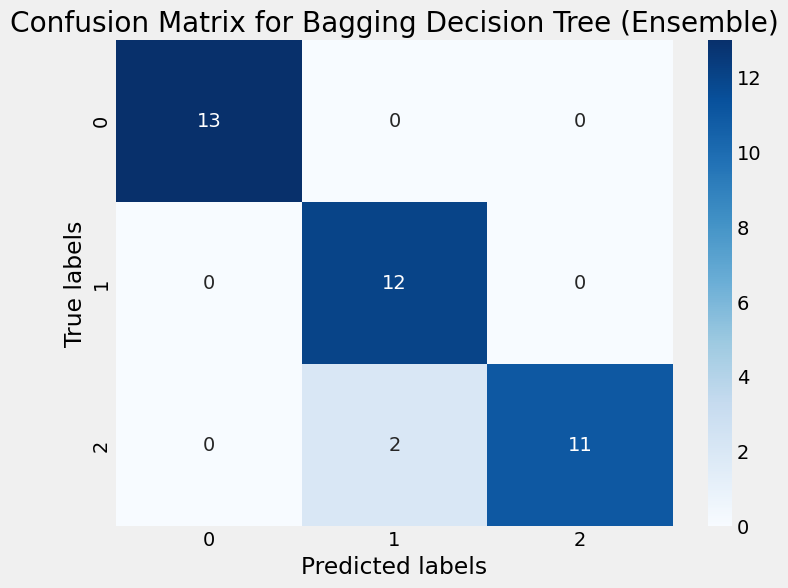

Classification Report for Bagging Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92        12
           2       1.00      0.85      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



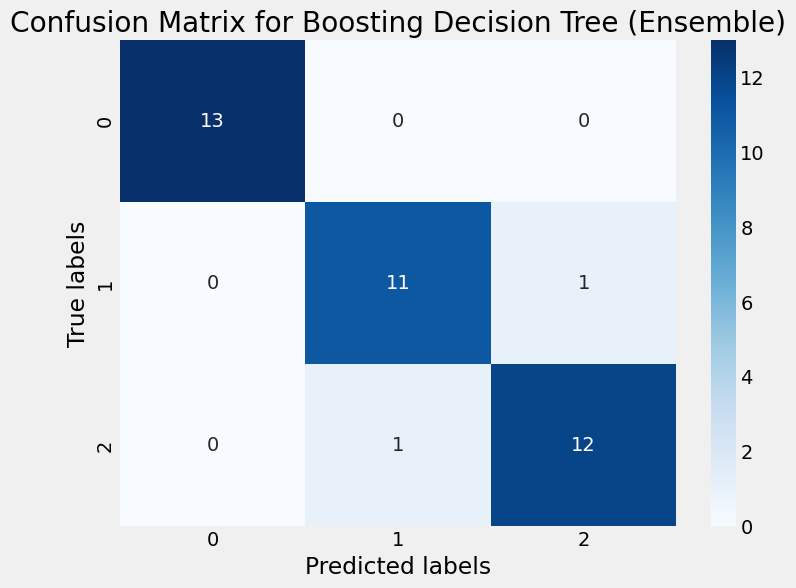

Classification Report for Boosting Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



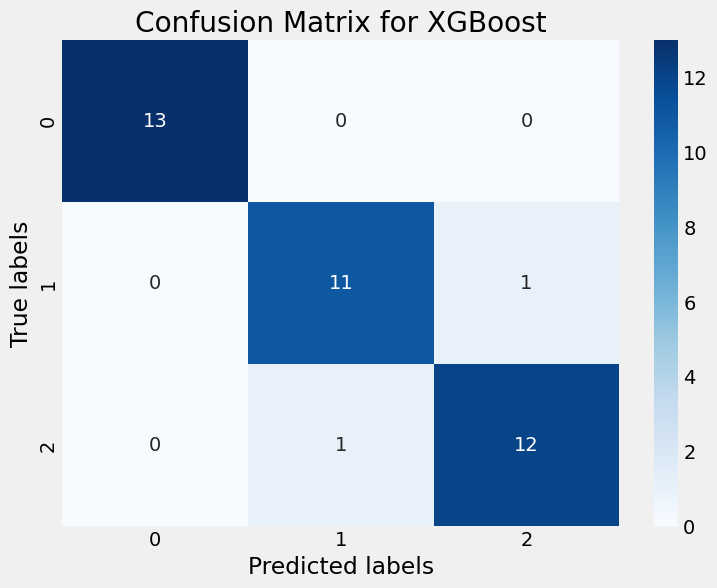

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [31]:
# Plot confusion matrices for the top three classifiers
for i in range(3):
    model_name = output.iloc[i]['Model']
    y_pred = predictions[model_name]

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    report = classification_report(y_test, y_pred)
    print(f'Classification Report for {model_name}:')
    print(report)

### Dimensionality Reduction through PCA

We now perform dimensionality reduction through PCA. We will first define a function to preserve 95% of the variance in PCA.

In [32]:
def pca_dimensionality_reduction(iris, X, y):
    """
    Perform PCA for dimensionality reduction on the Iris dataset and evaluate classifiers.

    Parameters:
    - iris: pd.DataFrame
        DataFrame containing the Iris features and flower species.
    - X: pd.DataFrame
        Iris features.
    - y: pd.Series
        Iris labels.

    Returns:
    - output_pca: pd.DataFrame
        DataFrame containing the performance metrics of each classifier after PCA.
    - predictions_pca: dict
        Dictionary containing the predictions of each classifier after PCA.
    """

    # Apply PCA
    pca = PCA(n_components=0.95)  # Preserve 95% of the variance
    pca_features = pca.fit_transform(X)

    print("PCA Components Shape:", pca_features.shape)
    print("Explained Variance:", pca.explained_variance_)
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)

    # Split the dataset into training and testing sets
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_features, y, test_size=0.25, random_state=42)

    # Convert arrays to DataFrames
    X_train_pca_df = pd.DataFrame(X_train_pca)
    X_test_pca_df = pd.DataFrame(X_test_pca)

    # Evaluate classifiers on the PCA-transformed data
    output_pca, predictions_pca = evaluate_classifiers(X_train_pca_df, X_test_pca_df, y_train_pca, y_test_pca)

    return output_pca, predictions_pca

We can preserve 95% of the variance with only two out of the four features.

In [33]:
output_pca, predictions_pca = pca_dimensionality_reduction(iris_df, X, y)

PCA Components Shape: (152, 2)
Explained Variance: [4.20682974 0.24622477]
Explained Variance Ratio: [0.92309072 0.05402829]


We get slightly better performance results with these two features.

In [34]:
output_pca

,Model,Train Accuracy,Test Accuracy,Max CrossVal,Precision,Recall,F1 Score,Timespan
0,Support Vector Machine,0.956140,0.947368,1.0,0.959316,0.956126,0.956046,0:00:00.253
1,Decision Tree,1.000000,0.947368,1.0,0.966925,0.956126,0.964697,0:00:00.228
2,Bagging Decision Tree (Ensemble),0.991228,0.947368,1.0,0.959195,0.964822,0.956001,0:00:00.689
3,Boosting Decision Tree (Ensemble),1.000000,0.947368,1.0,0.962673,0.956126,0.955529,0:00:00.503
4,Random Forest (Ensemble),1.000000,0.947368,1.0,0.961248,0.973518,0.946995,0:00:01.190
5,XGBoost,1.000000,0.947368,1.0,0.950620,0.947431,0.947306,0:00:01.041
6,Voting Classifier (Ensemble),0.991228,0.947368,1.0,0.959195,0.947036,0.964697,0:00:02.259
7,Logistic Regression,0.964912,0.921053,1.0,0.966925,0.964822,0.964697,0:00:00.317
8,K-Nearest Neighbors,0.991228,0.868421,1.0,0.968857,0.964822,0.964629,0:00:00.475


The Support Vector Machine model had the highest test accuracy.

In [35]:
Highest_Test_Accuracy_pca = output_pca.sort_values(by= 'Test Accuracy',ascending= False).Model
Highest_Test_Accuracy_pca

0               Support Vector Machine
1                        Decision Tree
2     Bagging Decision Tree (Ensemble)
3    Boosting Decision Tree (Ensemble)
4             Random Forest (Ensemble)
5                              XGBoost
6         Voting Classifier (Ensemble)
7                  Logistic Regression
8                  K-Nearest Neighbors
Name: Model, dtype: object

And the Decision Tree model had the highest F1 score.

In [36]:
Highest_F1_Score_pca = output_pca.sort_values(by= 'F1 Score',ascending= False).Model
Highest_F1_Score_pca

1                        Decision Tree
6         Voting Classifier (Ensemble)
7                  Logistic Regression
8                  K-Nearest Neighbors
0               Support Vector Machine
2     Bagging Decision Tree (Ensemble)
3    Boosting Decision Tree (Ensemble)
5                              XGBoost
4             Random Forest (Ensemble)
Name: Model, dtype: object

Also, the Decision Tree method took the least amount of processing time.

In [37]:
Fastest_pca = output_pca.sort_values(by= 'Timespan').Model
Fastest_pca

1                        Decision Tree
0               Support Vector Machine
7                  Logistic Regression
8                  K-Nearest Neighbors
3    Boosting Decision Tree (Ensemble)
2     Bagging Decision Tree (Ensemble)
5                              XGBoost
4             Random Forest (Ensemble)
6         Voting Classifier (Ensemble)
Name: Model, dtype: object

As before, the top three classifiers are Bagging Decision Tree (Ensemble), Boosting Decision Tree (Ensemble), and XGBoost classifiers.

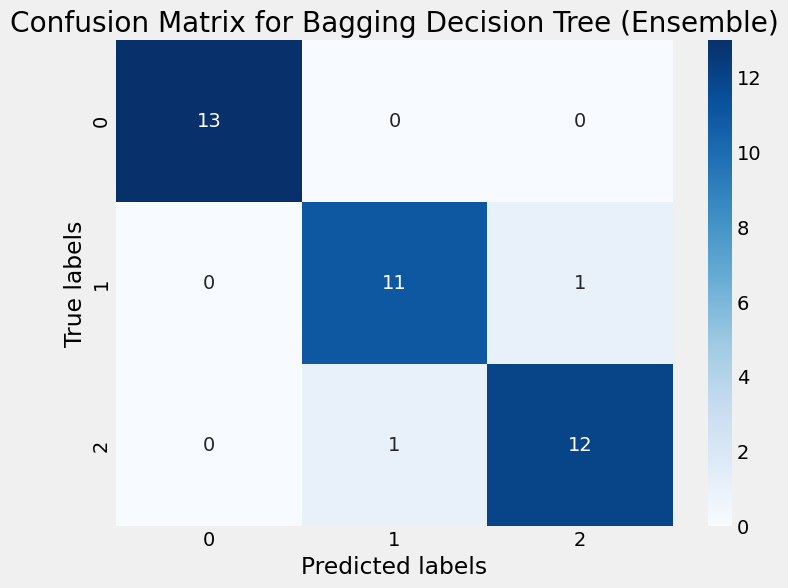

Classification Report for Bagging Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



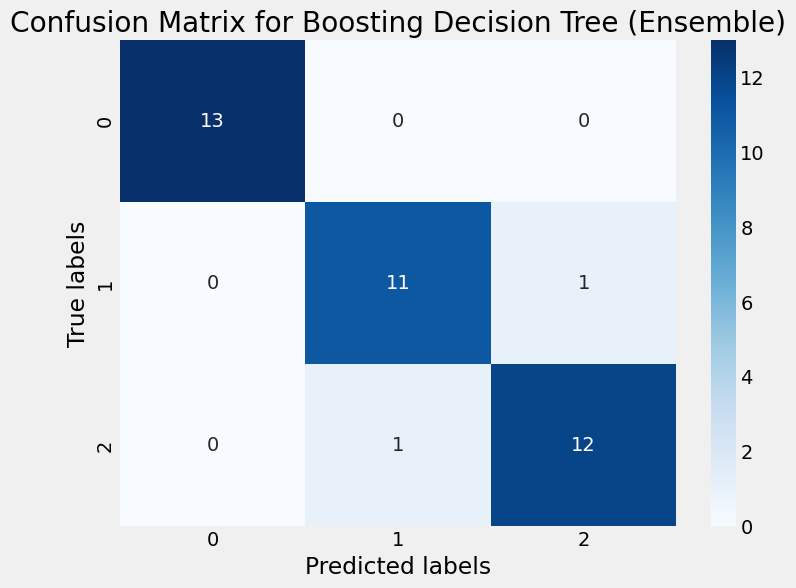

Classification Report for Boosting Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



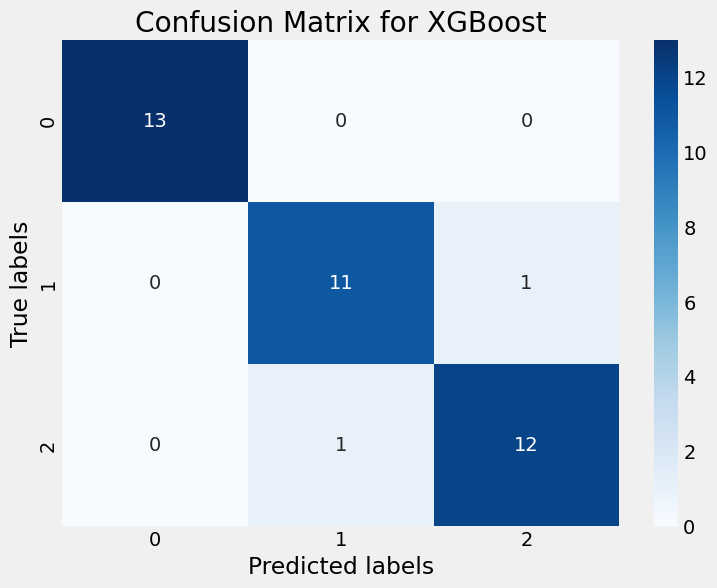

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [46]:
# Plot confusion matrices for the top three classifiers
for i in range(3):
    model_name = output.iloc[i]['Model']
    y_pred = predictions_pca[model_name]

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    report = classification_report(y_test, y_pred)
    print(f'Classification Report for {model_name}:')
    print(report)

## Feature Importance

As a final comparison, we will examine the importance of our four numerical features.

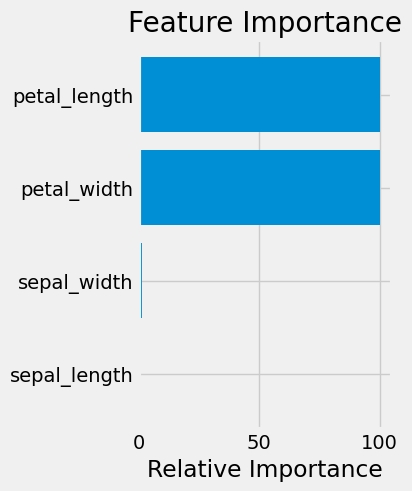

In [39]:
from sklearn import ensemble

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'log_loss'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()


We see that Petal Length and Pedal Width are the most important features. Let's analyze these two features and rerun our ML models.

In [40]:
X_reduced = iris_df[['petal_length', 'petal_width']]
y = iris_df['species']
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.25, random_state=42)

output_reduced, predictions_reduced = evaluate_classifiers(X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced)
output_reduced

,Model,Train Accuracy,Test Accuracy,Max CrossVal,Precision,Recall,F1 Score,Timespan
0,K-Nearest Neighbors,0.973684,0.947368,1.0,0.966925,0.964822,0.964741,0:00:00.350
1,Logistic Regression,0.964912,0.947368,1.0,0.966925,0.964822,0.964741,0:00:00.357
2,Support Vector Machine,0.964912,0.947368,1.0,0.958074,0.956126,0.955466,0:00:00.366
3,Bagging Decision Tree (Ensemble),0.982456,0.947368,1.0,0.953012,0.964822,0.955529,0:00:01.017
4,XGBoost,0.991228,0.947368,1.0,0.961248,0.956126,0.955270,0:00:01.067
5,Voting Classifier (Ensemble),0.973684,0.947368,1.0,0.950344,0.947431,0.946692,0:00:02.239
6,Decision Tree,0.991228,0.921053,1.0,0.962673,0.956126,0.955529,0:00:00.395
7,Boosting Decision Tree (Ensemble),0.991228,0.921053,1.0,0.968857,0.964822,0.964629,0:00:00.883
8,Random Forest (Ensemble),0.991228,0.921053,1.0,0.968857,0.964822,0.964629,0:00:01.560


The K-Nearest Neighbors model had the highest test accuracy.

In [41]:
Highest_Test_Accuracy_reduced = output_reduced.sort_values(by= 'Test Accuracy',ascending= False).Model
Highest_Test_Accuracy_reduced

0                  K-Nearest Neighbors
1                  Logistic Regression
2               Support Vector Machine
3     Bagging Decision Tree (Ensemble)
4                              XGBoost
5         Voting Classifier (Ensemble)
6                        Decision Tree
7    Boosting Decision Tree (Ensemble)
8             Random Forest (Ensemble)
Name: Model, dtype: object

And the K-Nearest Neighbors model had the highest F1 score.

In [42]:
Highest_F1_Score_reduced = output_reduced.sort_values(by= 'F1 Score',ascending= False).Model
Highest_F1_Score_reduced

0                  K-Nearest Neighbors
1                  Logistic Regression
7    Boosting Decision Tree (Ensemble)
8             Random Forest (Ensemble)
3     Bagging Decision Tree (Ensemble)
6                        Decision Tree
2               Support Vector Machine
4                              XGBoost
5         Voting Classifier (Ensemble)
Name: Model, dtype: object

As K-Nearest Neighbors method took the least amount of processing time.

In [43]:
Fastest_reduced = output_reduced.sort_values(by= 'Timespan').Model
Fastest_reduced

0                  K-Nearest Neighbors
1                  Logistic Regression
2               Support Vector Machine
6                        Decision Tree
7    Boosting Decision Tree (Ensemble)
3     Bagging Decision Tree (Ensemble)
4                              XGBoost
8             Random Forest (Ensemble)
5         Voting Classifier (Ensemble)
Name: Model, dtype: object

As in the other cases, the top three classifiers are Bagging Decision Tree (Ensemble), Boosting Decision Tree (Ensemble), and XGBoost classifiers.

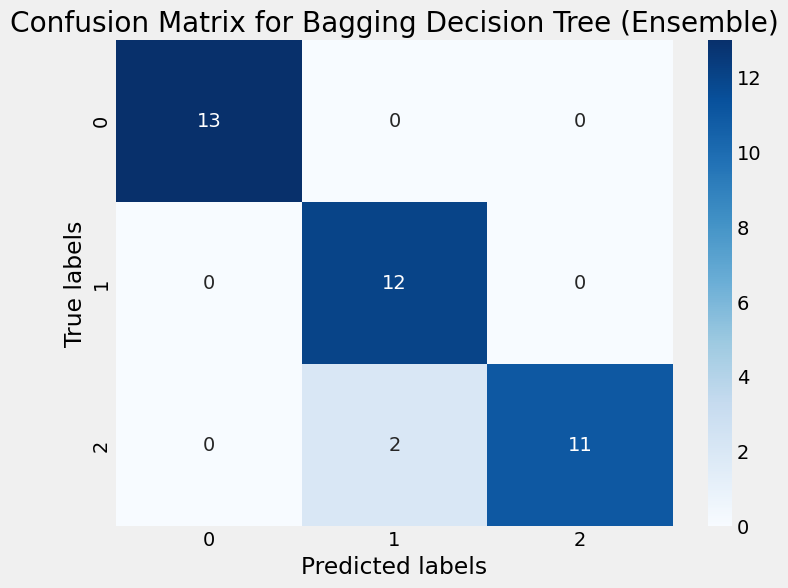

Classification Report for Bagging Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92        12
           2       1.00      0.85      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



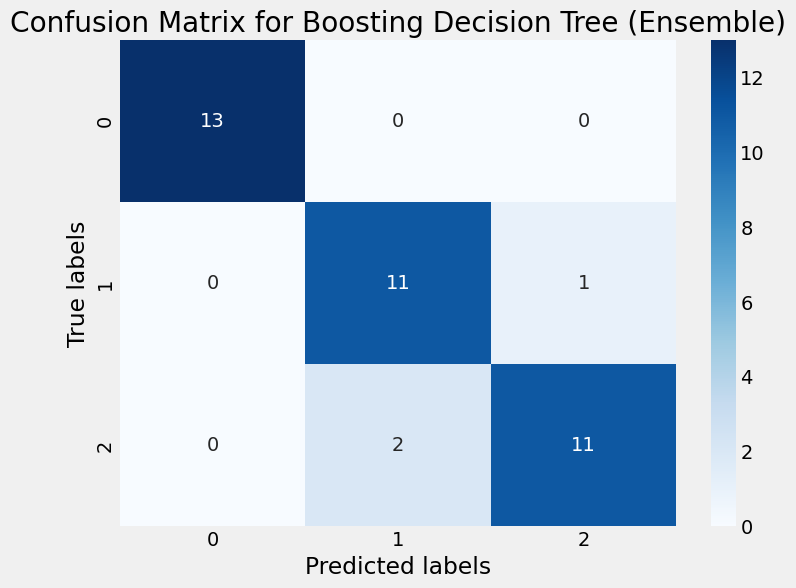

Classification Report for Boosting Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.85      0.92      0.88        12
           2       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



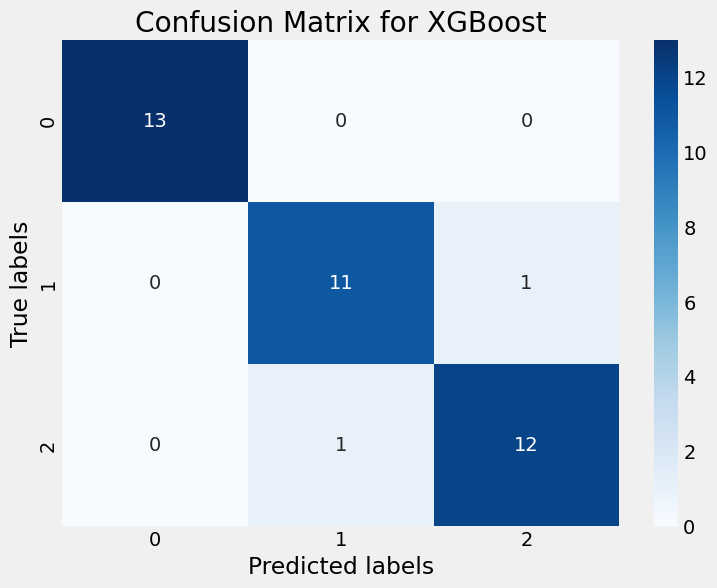

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [47]:
# Plot confusion matrices for the top three classifiers
for i in range(3):
    model_name = output.iloc[i]['Model']
    y_pred_reduced = predictions_reduced[model_name]

    cm = confusion_matrix(y_test_reduced, y_pred_reduced)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    report = classification_report(y_test_reduced, y_pred_reduced)
    print(f'Classification Report for {model_name}:')
    print(report)

### Best Performing Model

Through examine our different cases, we saw that these six models had comparable performance:

- Support Vector Machine
- Decision Tree
- Bagging Decision Tree (Ensemble)
- Boosting Decision Tree (Ensemble)
- Random Forest (Ensemble)
- XGBoost

Further examination could be performed through using GridSearchCV to see which classifier has the best performance.

## Discussion and Recommendations

By analyzing the Iris dataset, we implemented a workflow to preprocess, visualize, and model the data. Our primary steps are:

- Data Preprocessing:
        
   - Addressed missing values by shifting column values to the right and replacing the sepal_length with the mean specific to each species.
   - Applied feature scaling and encoding to ensure the dataset was ready for machine learning algorithms.

- Visual Analysis:
  - Generated scatter plots and pair plots to explore relationships between features.
  - Found that Iris Setosa was distinguishable from the other species, while Iris Versicolor and Iris Virginica often overlapped.

- Dimensionality Reduction and Feature Reduction:
  - Conducted Principal Component Analysis (PCA) to reduce the dataset's dimensionality, preserving 95% of the variance.
  - The PCA transformation helped us simplify the number of features in the dataset, maintaining essential information for effective modeling.
  - Feature reduction showed that Petal Length and Pedal Width are the most important features.

- Model Evaluation:
   - Evaluated multiple classifiers including K-Nearest Neighbors, Logistic Regression, SVM, Decision Trees, and ensemble methods.
   - Assessed models using cross-validation, focusing on accuracy, precision, recall, and F1 score. The Random Forest and Voting Classifier showed the best performance.
   - Visualized confusion matrices for the top performers, providing insights into their metrics.

Through our analysis, we demonstrated the importance of data cleaning,  preprocessing, and exploration in preparing data for machine learning. The visualizations provided insights into feature relationships and separability of species, guiding our modeling efforts. Evaluating a diverse set of classifiers allowed us to identify the most effective models for this dataset, emphasizing the value of testing multiple models.

This systematic approach to analyzing the Iris dataset can be applied to a variety of supervised machine learning problems.

